In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import os
from dateutil import parser
from mossbauer_analysis.mossbauer_theory import CobaltRhodium, CobaltFe, KFeCy, alphaFe, Mossbauer
from mossbauer_analysis.fit_functions import linear,single_peak_lorentzian_poly1, single_peak_lorentzian_poly2, six_peak_lorentzian_poly1,six_peak_lorentzian_poly2, six_peak_lorentzian_poly5
from mossbauer_analysis.load_spectrum import read_ironanalytics_data, print_ironanalytics_metadata 
import mossbauer_analysis.utils as u
from mossbauer_analysis.analyse_file import fit_and_calibrate


In [3]:
dir ='C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/saw_spectra_6mms/'
print_ironanalytics_metadata(dir)

ID: A00099,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: AGM_TN02_SN01_m09dBm_glued_W_06mmps
ID: A00100,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: AGM_TN02_SN01_m100dBm_glued_W_06mmps


## Now all the SAW measurements

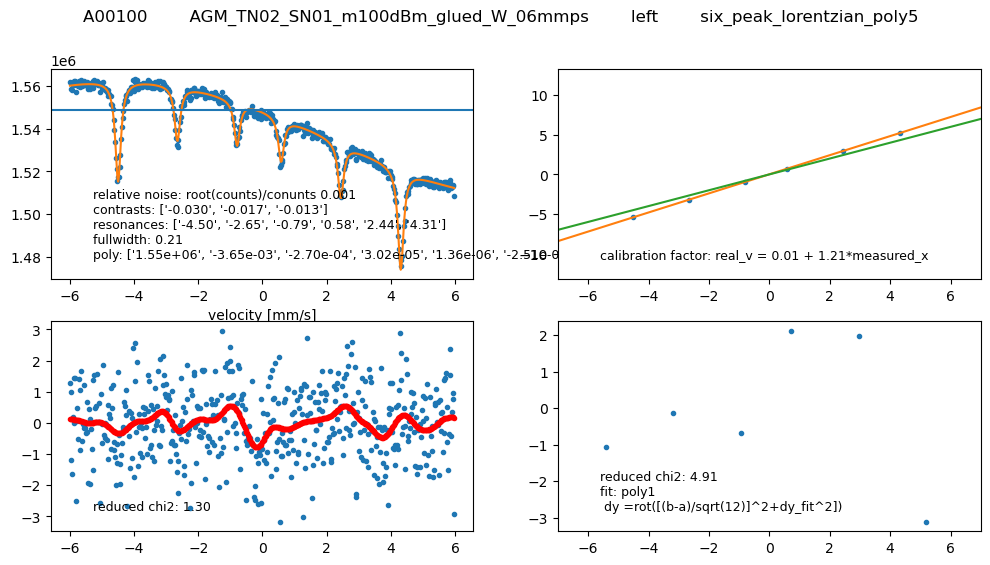

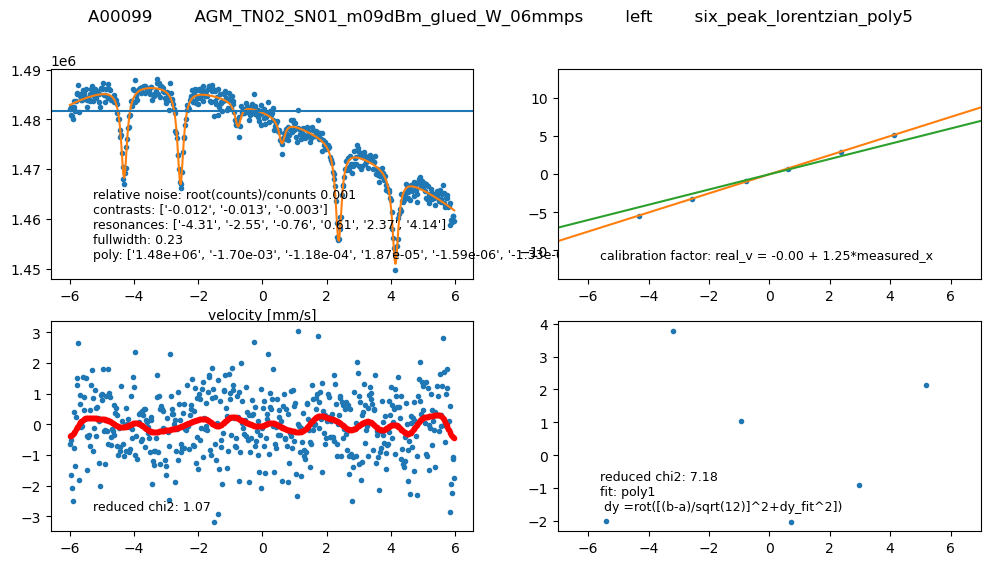

In [36]:
fit_guess = {
            'contrasts': [-1e-1, -1e-1, -1e-1],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.41,4.09],
            'fullwidth': 0.2,
            'poly': [1e6, 1e2, 1e-5,1e-5,1e-5,1e-5],  # polynomial coefficients for a 5th order polynomial
            }


params = {  'directory':  'C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/saw_spectra_6mms/',
            'id': 'A00051',
            'offset': -1,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': np.array([-5.48, -3.25, -1.01, 0.66, 2.90, 5.13])-0.109+0.177,
        
        } 


params_out = []
for id in ['A00100','A00099']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = True, plot = True))

        params_out

In [37]:
def poly5(p,x):
    """5th order polynomial"""
    return p[0]*(1+p[1]*x + p[2]*x**2 + p[3]*x**3 + p[4]*x**4 + p[5]*x**5)


def six_peak_lorentzian(p, x):
    
    c0, c1, c2, x0, x1, x2, x3, x4, x5, fullwidth = p
    constrasts = [c0, c1, c2, c2, c1, c0]
    
    resonances = [x0, x1, x2, x3, x4, x5]
    peaks = np.zeros_like(x, dtype=float)

    for c_i, x_i in zip(constrasts, resonances):
        peaks += c_i*(fullwidth/2)**2 / ((x - x_i)**2 + (fullwidth/2)**2)
    
    return 1 + peaks
    

In [38]:
params_out[0]

{'directory': 'C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/saw_spectra_6mms/',
 'id': 'A00100',
 'offset': -1,
 'side': 'left',
 'npeaks': 6,
 'fitfunction': <function mossbauer_analysis.fit_functions.six_peak_lorentzian_poly5(p, x)>,
 'calibration_resonances': array([-5.412, -3.182, -0.942,  0.728,  2.968,  5.198]),
 'description': 'AGM_TN02_SN01_m100dBm_glued_W_06mmps',
 'reduced_chi2': 1.29832381947165,
 'total_rate': 1423.24216912434,
 'total_counts': 1563573847,
 'total_time': 1098600.0,
 'resonances': [-4.499581616564535,
  -2.652059641535663,
  -0.7911538069986406,
  0.5826833138088628,
  2.44274699651425,
  4.310272517069574],
 'contrasts': [-0.030411046830009735,
  -0.016569214379089515,
  -0.013359225990567944],
 'fullwidth': 0.2132633047370714,
 'poly': [1548719.9670042647,
  -0.0036479060173405142,
  -0.00026968407564673493,
  3.023896064046531e-05,
  1.358981899548469e-06,
  -2.506266330993795e-08],
 'velocity_calibration': array([0.01494614, 1

(2.0, 6.0)

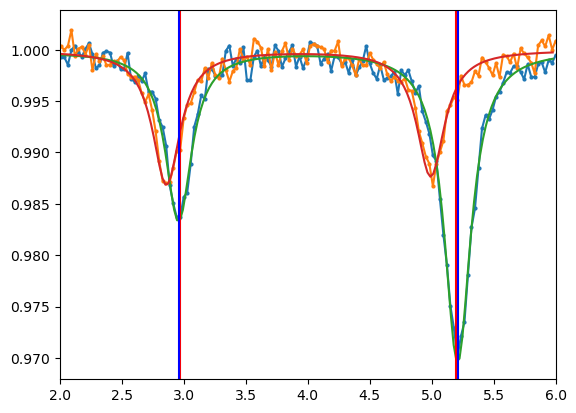

In [57]:
data = read_ironanalytics_data(dir, 'A00100', offset = -1)
ref_time = data.start_time.timestamp()
#counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
#print(data.start_time, data.total_time/3600/24)
a,b = params_out[0]['velocity_calibration']
x = data.velocity_list[1:]
x_cal = a + b*x
y = data.data_left[1:]/poly5(params_out[0]['poly'],x)
plt.plot(x_cal,y,'.-', markersize = 4)
#plt.plot(x,poly5(params_out[0]['poly'],x ))

data = read_ironanalytics_data(dir, 'A00099', offset = -1)
#counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
#print(data.start_time, data.total_time/3600/24, counts)
a,b = params_out[0]['velocity_calibration']
x = data.velocity_list[1:]
x_cal = a + b*x
y = data.data_left[1:]/poly5(params_out[1]['poly'],x)
plt.plot(x_cal,y,'.-', markersize = 4)
#plt.plot(x,poly5(params_out[0]['poly'],x ))

contrasts0 = params_out[0]['contrasts']
resonances0 = a + b * np.array(params_out[0]['resonances'])
fullwidth0 = b * params_out[0]['fullwidth']
params0 = list(contrasts0) + list(resonances0) + [fullwidth0]
delta = 8.42
x2 = np.linspace(-16,16,1000)

paramsm1 = list(contrasts0) + list(resonances0-delta) + [fullwidth0]
paramsp1 = list(contrasts0) + list(resonances0+2*delta) + [fullwidth0]
plt.plot(x, six_peak_lorentzian(params0, x ))


contrasts1 = params_out[1]['contrasts']
resonances1 = np.array(params_out[1]['resonances'])*params_out[0]['velocity_calibration'][1]
fullwidth1 = params_out[1]['fullwidth']*params_out[0]['velocity_calibration'][1]
params1 = list(contrasts1) + list(resonances1) + [fullwidth1]
plt.plot(x, six_peak_lorentzian(params1, x ))

#plt.plot(x2, six_peak_lorentzian(paramsm1, x2 ))
#plt.plot(x2, six_peak_lorentzian(paramsp1, x2 ))
#plt.axvline(-delta)
#plt.axvline(-5.48+delta)
#plt.axvline(-3.25+delta)

epsilon = 0.3
epsilon2 = 0.6
#plt.axvline(-5.48+delta-epsilon/2)
#plt.axvline(-3.25+delta-epsilon)

#for mult, res in zip([3,2,1,1,2,3],params['calibration_resonances']):
   # plt.axvline(res+delta-epsilon/mult)
   # plt.axvline(res-delta+epsilon2/mult)

for res in params['calibration_resonances']:
    plt.axvline(res,color = 'r')

a,b = params_out[0]['velocity_calibration']
for res in params_out[0]['resonances']:
    plt.axvline(res*b+a,color = 'b')
    
plt.axvline((0.728-0.942)/2)
plt.xlim(2,6)

In [42]:
params['calibration_resonances']

array([-5.412, -3.182, -0.942,  0.728,  2.968,  5.198])

2025-05-30 16:44:00 12.715277777777779


(-6.0, -4.0)

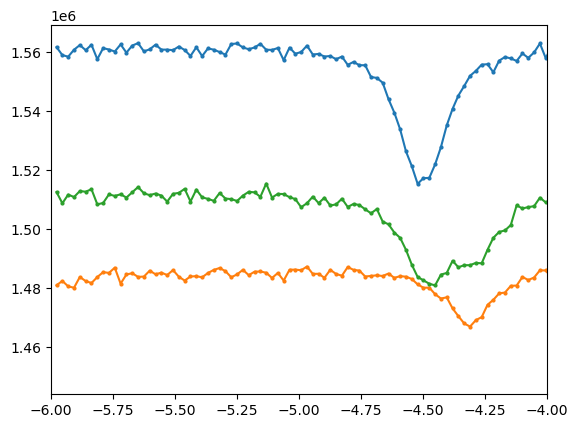

In [9]:
data = read_ironanalytics_data(dir, 'A00100', offset = -1)
ref_time = data.start_time.timestamp()
#counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
print(data.start_time, data.total_time/3600/24)
x = data.velocity_list[1:]
y = data.data_left[1:]
plt.plot(x,y,'.-', markersize = 4)
#plt.plot(x,poly5(params_out[0]['poly'],x ))

data = read_ironanalytics_data(dir, 'A00099', offset = -1)
#counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
#print(data.start_time, data.total_time/3600/24, counts)
x = data.velocity_list[1:]
y = data.data_left[1:]
plt.plot(x,y,'.-', markersize = 4)
#plt.plot(x,poly5(params_out[1]['poly'],x ))
#plt.xlim(-5.5,-0)

data = read_ironanalytics_data(dir, 'A00102', offset = -1)
#counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
#print(data.start_time, data.total_time/3600/24, counts)
x = data.velocity_list[1:]
y = data.data_left[1:]*1.4
plt.plot(x,y,'.-', markersize = 4)
#plt.plot(x,poly5(params_out[1]['poly'],x ))
plt.xlim(-6,-4)


2025-05-30 16:44:00 12.715277777777779
2025-05-20 14:03:00 10.11111111111111 884962.0916585524


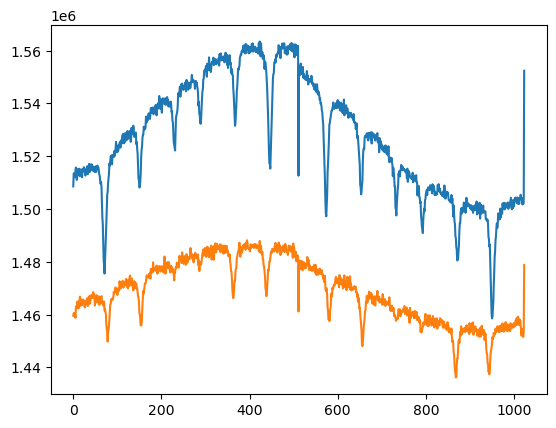

In [165]:
data = read_ironanalytics_data(dir, 'A00100', offset = -1)
ref_time = data.start_time.timestamp()
counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
print(data.start_time, data.total_time/3600/24)
x = data.velocity_list[1:]
y = data.data#/counts
plt.plot(y)
#plt.plot(x,poly5(params_out[0]['poly'],x ))

data = read_ironanalytics_data(dir, 'A00099', offset = -1)
counts = integrated_counts(activity_0=1,halflife_days=271.8, reference_timestamp = ref_time, start_timestamp = data.start_time.timestamp(), duration_seconds = data.total_time)
print(data.start_time, data.total_time/3600/24, counts)
x = data.velocity_list[1:]
polyparams = params_out[0]['poly'].copy()
polyparams[0] = params_out[1]['poly'][0]
y = data.data#/counts
plt.plot(y)
#plt.plot(x,poly5(params_out[1]['poly'],x ))

In [199]:
0.21*1.2-0.23*1.25

-0.03550000000000003